In [2]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for pandas 
import statsmodels.formula.api as smf

%matplotlib inline                     

# Data Bootcamp Final Project: Analyzing the Ultimate Fighting Championship

### Team: Benjamin Robson and Tommy Martinez

The Ultimate Fighting Championship is a mixed martial arts league in the United States where fighters from countries around the world compete. For our project we analyzed data on UFC fights taken from Sherdog.com, a UFC-tracking site. Our first goal was to find out more about which countries' fighters have competed in the most matches, which countries produce the most successful fighters and what method fighters from each country predominantly use to end fights, such as arms bars or rear-naked chokes. Our second goal was to take a deeper look at factors that contribute to fighter success. To that end, we analyzed the effect of both crime rates and gdp per capita in each country on that country's success rate int the UFC. We used United Nations  average crime data over the period 2003-2015 for each country and data on GDP PPP Per Capita from the World Bank.

We found that fighters from the United States have competed in the most fights, followed by Brazil; that Iceland has the best record overall in the UFC, although its fighters have competed in very few matches; and that unanimous decision by judges is the most common method by which fights are decided. Additionally, we found that there is a slightly positive correlation between homicide rates and assault rates and a country's win/loss record in the UFC, and a slightly negative correlation between GDP PPP Per Capita and win/loss record. 

Running an OLS regression, however, we found that the relationship between each of the variables we tested was not statistically significant after controlling for the other variables. This seems to have been caused by the fact that, because only around 40 countries have fighters in the UFC, and thus the data on which we ran the OLS regression has around 40 rows, the condition number is large, meaning changes in our input variables could cause dramtic changes in the output.


### Section I: Loading, Cleaning, and Merging UFC Data

We have two separate datasets: One with a list of fighters and their home country and another with a list of every fight from November 1993 to February 2016 including the names of the fighters in each fight, the winners of each fight, and the method used to end each fight. Because we want to analyze the data at a country level, we need to merge the two data frames in order to display the home countries of each fighter in each fight.

In order to do so: we did the following:

In [3]:
#Here we load the fighter/country dataset

names = 'C:/Users/Benjamin Robson/Documents/UFC_fighters_name_location.csv'
ufc_names = pd.read_csv(names)               # tab (\t) separated values 

To clean ufc_names, we needed to standardize the names for two countries as shown below.

In [4]:
ufc_names['country'] = ufc_names['country'].replace({"USA": "United States", "Holland":"Netherlands"})

Here we load the second dataset which shows information about each fight. [f1name] and [f2name] are the names of the two fighters in each fight, with f1 being the winner and f2 the loser.


In [53]:
fights = 'C:/Users/Benjamin Robson/Documents/all_ufc_fights.csv'
ufc_fights = pd.read_csv(fights)

In order to merge the two dataframes, we need to have a common column in both dataframes to merge on; in this case, we merge on fighter name. To do so, we created two new dataframes simply by renaming the 'name' column in the ufc_names dataframe to 'f1name'  and 'f2name' as they appear in the ufc_fights dataframe. We also took the opportunity to drop any duplicates from each dataframe.

In [6]:
ufc_names1 = ufc_names.rename(columns={'name': 'f1name','country': 'f1country' })

In [7]:
ufc_names1 = ufc_names1.drop_duplicates(subset='f1name')

In [8]:
ufc_names2 = ufc_names.rename(columns={'name': 'f2name', 'country': 'f2country'})

In [9]:
ufc_names2 = ufc_names2.drop_duplicates(subset='f2name')

Here we do a left merge on f1name to add a column displaying the homecountry of the the f1 fighters to the ufc_fights dataframe. The new column is called 'f1country'.

In [54]:
ufc1 = pd.merge(ufc_fights, ufc_names1, on='f1name', how = 'left').drop_duplicates()

Here we do the same as above for the f2 fighters, adding column 'f2country'

In [55]:
ufc_final = pd.merge(ufc1, ufc_names2, on='f2name', how = 'left').drop_duplicates()

We next dropped several irrelevant columns so that we could view the whole dataframe.

In [12]:
fighterscolumns=['pageurl','f1pageurl','f2pageurl', 'event_org', 'eid', 'mid', 'event_name', 'ref', 'round', 'f1fid', 'f2fid']

## Section II: Calculating the Record for Each Country

In order to find the number of wins and losses for each country, to ultimately calculate each country's win/loss record, we sum the number of times each country appears in the f1country and f2country columns. Because all of the f1 fighters are the winners in each fight, the f1country column correspondingly represents the winning country in each fight. Running value counts on the f1country columns, thus, shows the total number of wins for each country, while value counts on the f2country column shows the total number of losses. We create two dataframes with value counts for f1country and f2country in order to then merge them and run arithmetic functions across rows in the merged dataframe to calculate each country's win/loss record.

In [56]:
win_country_count = ufc_final['f1country'].value_counts().to_frame().reset_index()
loss_country_count = ufc_final['f2country'].value_counts().to_frame().reset_index()

In [57]:
country_count = pd.merge(win_country_count, loss_country_count, on='index')
country_count

,index,f1country,f2country
0,United States,2199,2248
1,Brazil,547,438
2,Canada,184,187
3,England,111,132
4,Japan,75,118
5,Russia,52,28
6,Australia,48,56
7,Netherlands,36,29
8,South Korea,28,18
9,Sweden,27,31


In [58]:
#here we relable the columns and set country as the index
country_count.columns = ['country', 'wins', 'losses']
country_count = country_count.set_index(['country'])

Here we create a new column summing wins and losses to find the total number of fights for each country. We then calculate the record for each country, dividing wins by total number of fights, and add this to a new column, 'record.'

In [59]:
country_count['total matches'] = country_count['wins'] + country_count['losses']

In [60]:
country_count['record'] = country_count['wins'] / country_count['total matches']

In [61]:
#country_count = country_count.reset_index()

In [62]:
country_count

,wins,losses,total matches,record
country,,,,
United States,2199,2248,4447,0.494491
Brazil,547,438,985,0.555330
Canada,184,187,371,0.495957
England,111,132,243,0.456790
Japan,75,118,193,0.388601
Russia,52,28,80,0.650000
Australia,48,56,104,0.461538
Netherlands,36,29,65,0.553846
South Korea,28,18,46,0.608696


## Section III: Examining Countries and Methods in UFC Fights

Below we looked at the top ten countries in terms of the number of fights in which their fighters have competed. From the graph, we see that the fighters from the United States have competed in the most fights, followed by Brazil, Canada, and England.

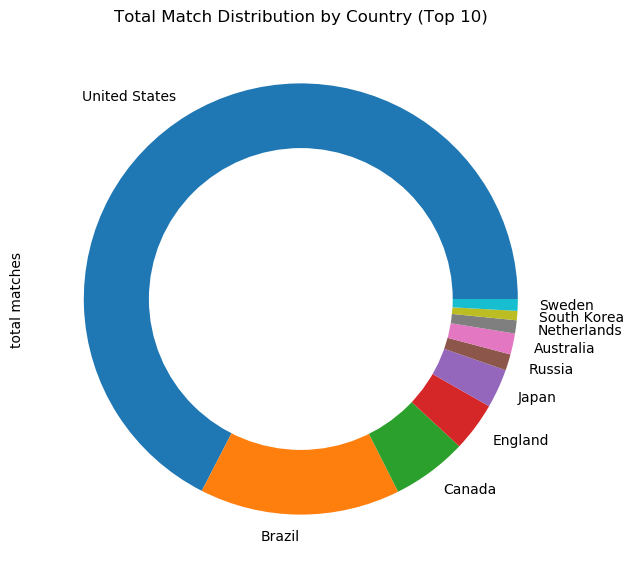

In [63]:
fig, ax = plt.subplots()
country_count.head(10).plot(y='total matches', ax=ax, kind = 'pie', figsize=(7,7), legend = False)
ax.set_title('Total Match Distribution by Country (Top 10)')

centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

We then depicted the win-ratio of each country as derived in dataframe country_count under the column 'record', from greatest to least. We now have a visual representation of how well each country does relative to the number of fights they have. Nonetheless, it should be noted that the bar graph does not control for total number of fights, so some countries with only a few fights may appear to do better or worse than their average over time in the future. Iceland, for example, has the highest win record of 0.71 but its fighters have won just seven fights.

Text(0.5,0,'Win Ratio')

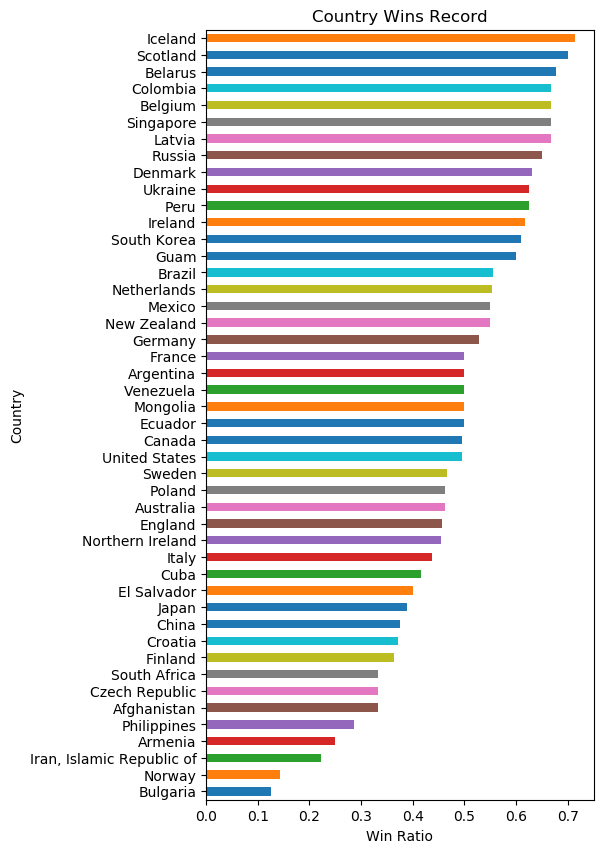

In [64]:
fig, ax = plt.subplots()
country_count['record'].sort_values().plot(kind='barh', figsize=(5,10))
ax.set_title('Country Wins Record', loc='center')
ax.set_ylabel('Country')
ax.set_xlabel('Win Ratio')

Next we look at the most common methods for ending fights. The first graph shows the four most common category of methods by which fights are ended, with Judges' decision being the most common type, followed by technical knockout (TKO), submission, and knockout (KO). The second pie chart shows the most common specific methods regardless of category. Unanimous decision is the most common way fights are decided, followed by punches, split decision, and rear-naked choke.

In [65]:
ufc_method = ufc_final.groupby('method')['method_d'].describe().dropna().sort_values(by = ['count'], ascending = False).head(4)
ufc_method

,count,freq,top,unique
method,,,,
Decision,1466,1140,Unanimous,3
TKO,777,490,Punches,64
Submission,768,252,Rear-Naked Choke,60
KO,413,178,Punches,34


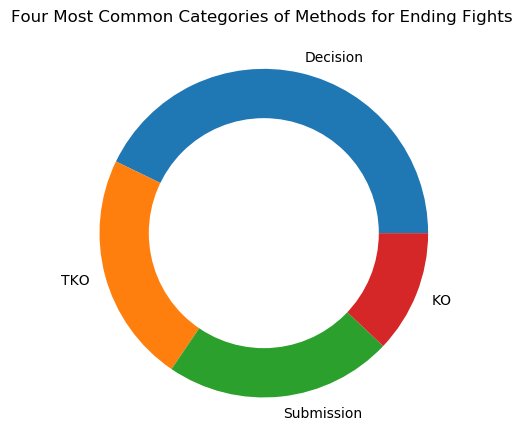

In [66]:
fig, ax = plt.subplots()
ufc_method.plot(y='count',ax=ax, kind = 'pie', legend = False)
ax.set_title('Four Most Common Categories of Methods for Ending Fights', y =1.05)
ax.axis('equal')
ax.set_ylabel('')

centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [67]:
ufc_method_d = ufc_final['method_d'].value_counts().to_frame()

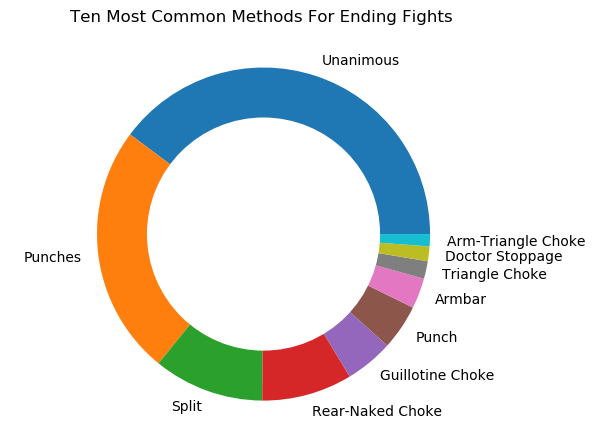

In [68]:
fig, ax = plt.subplots()
ufc_method_d.head(10).plot(y= "method_d", ax=ax, kind = 'pie', legend = False)
ax.set_title('Ten Most Common Methods For Ending Fights', y=1.05)
ax.axis('equal')
ax.set_ylabel('')

centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

Finally, we created a dataframe showing the most common method used by fighters from each country to end fights. The dataframe dsiplays each country name, the country's top method, and the frequency of that method. Fights won by fighters from the United States, for example, are decided most commonly by the judges' unanimous decision, which has happened 694 times, while fighters from the Netherlands most commonly end fights with punches, which has happened 12 times.

In [69]:
ufc_method_by_country = ufc_final.groupby('f1country')['method_d'].describe()

In [28]:
ufc_method_by_country.drop(['count', 'unique'], axis = 1).rename(columns = {'top': 'Top Method', 'freq':'Frequency'}).rename_axis('Country')

,Top Method,Frequency
Country,,
Afghanistan,Punch,1
Argentina,Punches,2
Armenia,Achilles Lock,1
Australia,Punches,13
Belarus,Punches,9
Belgium,Unanimous,2
Brazil,Unanimous,169
Bulgaria,Punches,1
Canada,Unanimous,71


## Section IV: Loading, Cleaning and Merging Data on Homicide Rate, Assault Rate, and GDP PPP Per Capita

Here we load in homicide data for each country from the United Nations. The figures represent number of homicides per 100,000 people.

In [70]:
homicide_data = 'C:/Users/Benjamin Robson/Documents/Homicide_rate_by_country.csv'
crime = pd.read_csv(homicide_data)

We then create a new data frame with two columns: country name and the corresponding average homicide rate over the years 2003-2015.

In [30]:
crime_average = crime[['country','Average']]

We next merge the average homicide rate with out UFC record dataframe on country.

In [71]:
country_record_crime = pd.merge(country_count, crime_average, on='country', how = 'left')

In [32]:
country_record_crime = country_record_crime.rename(columns={'Average': 'average homicide rate per 100,000 (2003-2015)'})

Next we upload assault data for each country, which is also from the United Nations.

In [33]:
assault = 'C:/Users/Benjamin Robson/Documents/un_assault_data.csv'
assault_data = pd.read_csv(assault)   

In [34]:
assault_data = assault_data[['Country', 'average assault rate per 100,000 people (2003-2015)']]  

In [35]:
assault_data = assault_data.rename(columns = {'Country':'country'})

We then merge the assault data with our UFC record data frame to show the assault rate for each country.

In [36]:
record_hom_assault = pd.merge(country_record_crime, assault_data, on = 'country', how = 'left')

We next upload our data on GDP PPP Per Capita, which comes from the World Bank.

In [38]:
gdp = 'C:/Users/Benjamin Robson/Documents/world_bank_gdp_ppp.csv'
gdp_ppp = pd.read_csv(gdp) 

In [39]:
gdp_ppp = gdp_ppp.rename(columns= {'Country Name': 'country', 'avg' : 'gdp ppp (average 2003-2015)'})

In [40]:
gdp_ppp_avg = gdp_ppp[['country', 'gdp ppp (average 2003-2015)' ]]

We then merge the GDP data with our UFC record data.

In [41]:
final = pd.merge(record_hom_assault, gdp_ppp_avg, on = 'country', how = 'left')

Here we convert the homicide rate data from an object to a float so that we can use it later to run a regression.

In [42]:
final['average homicide rate per 100,000 (2003-2015)'] = final['average homicide rate per 100,000 (2003-2015)'].astype(float)

In [72]:
final_x = final.set_index(['country'])

Here we remove spaces and commas from our column names as needed for the OLS regression to work properly later on.

In [76]:
final_x = final_x.rename(columns= {'average homicide rate per 100,000 (2003-2015)' : 'average_homicide_rate_per_100000', 'average assault rate per 100,000 people (2003-2015)' : 'average_assault_rate_per_100000', 'gdp ppp (average 2003-2015)' : 'average_gdp_ppp_per_capita' })

### Below is the final dataframe combining all the information from above.

In [77]:
final_x_index = final_x.reset_index()
final_x_index

,country,wins,losses,total matches,record,average_homicide_rate_per_100000,average_assault_rate_per_100000,average_gdp_ppp_per_capita
0,United States,2199,2248,4447,0.494491,5.131538,263.623077,48411.632740
1,Brazil,547,438,985,0.555330,24.697778,343.511250,8588.027429
2,Canada,184,187,371,0.495957,1.736923,158.084615,43634.300120
3,England,111,132,243,0.456790,1.265833,759.337500,42401.250010
4,Japan,75,118,193,0.388601,0.426667,34.650000,39617.631390
5,Russia,52,28,80,0.650000,13.535000,27.240000,9889.298925
6,Australia,48,56,104,0.461538,1.214615,296.293750,48158.685090
7,Netherlands,36,29,65,0.553846,0.897692,362.126154,47933.323840
8,South Korea,28,18,46,0.608696,0.782500,449.106667,21750.785270
9,Sweden,27,31,58,0.465517,0.966154,476.070000,51007.923590


## Section V: Examining the Relationship Between Assault Rate, Homicide Rate, GDP, and UFC Record

Here we create two new dataframes dropping NaN values from the assault rate and gdp columns so that our graphs below will work properly. Because doing so drops the entire row in which the NaN values appear, we need to create two separate dataframes for each column from which we drop NaN values, in order to avoid dropping rows where NaN values appear in one column but not the other.

In [78]:
final_x_index_dropna_a = final_x_index.dropna(subset=['average_assault_rate_per_100000'])
final_x_index_dropna_b = final_x_index.dropna(subset=['average_gdp_ppp_per_capita'])

We then graph each UFC record versus assault rate for each country. We use a loop to annotate each point with country name.

From the graph, we can see that there is a slightly positive correlation between assault rate and record.

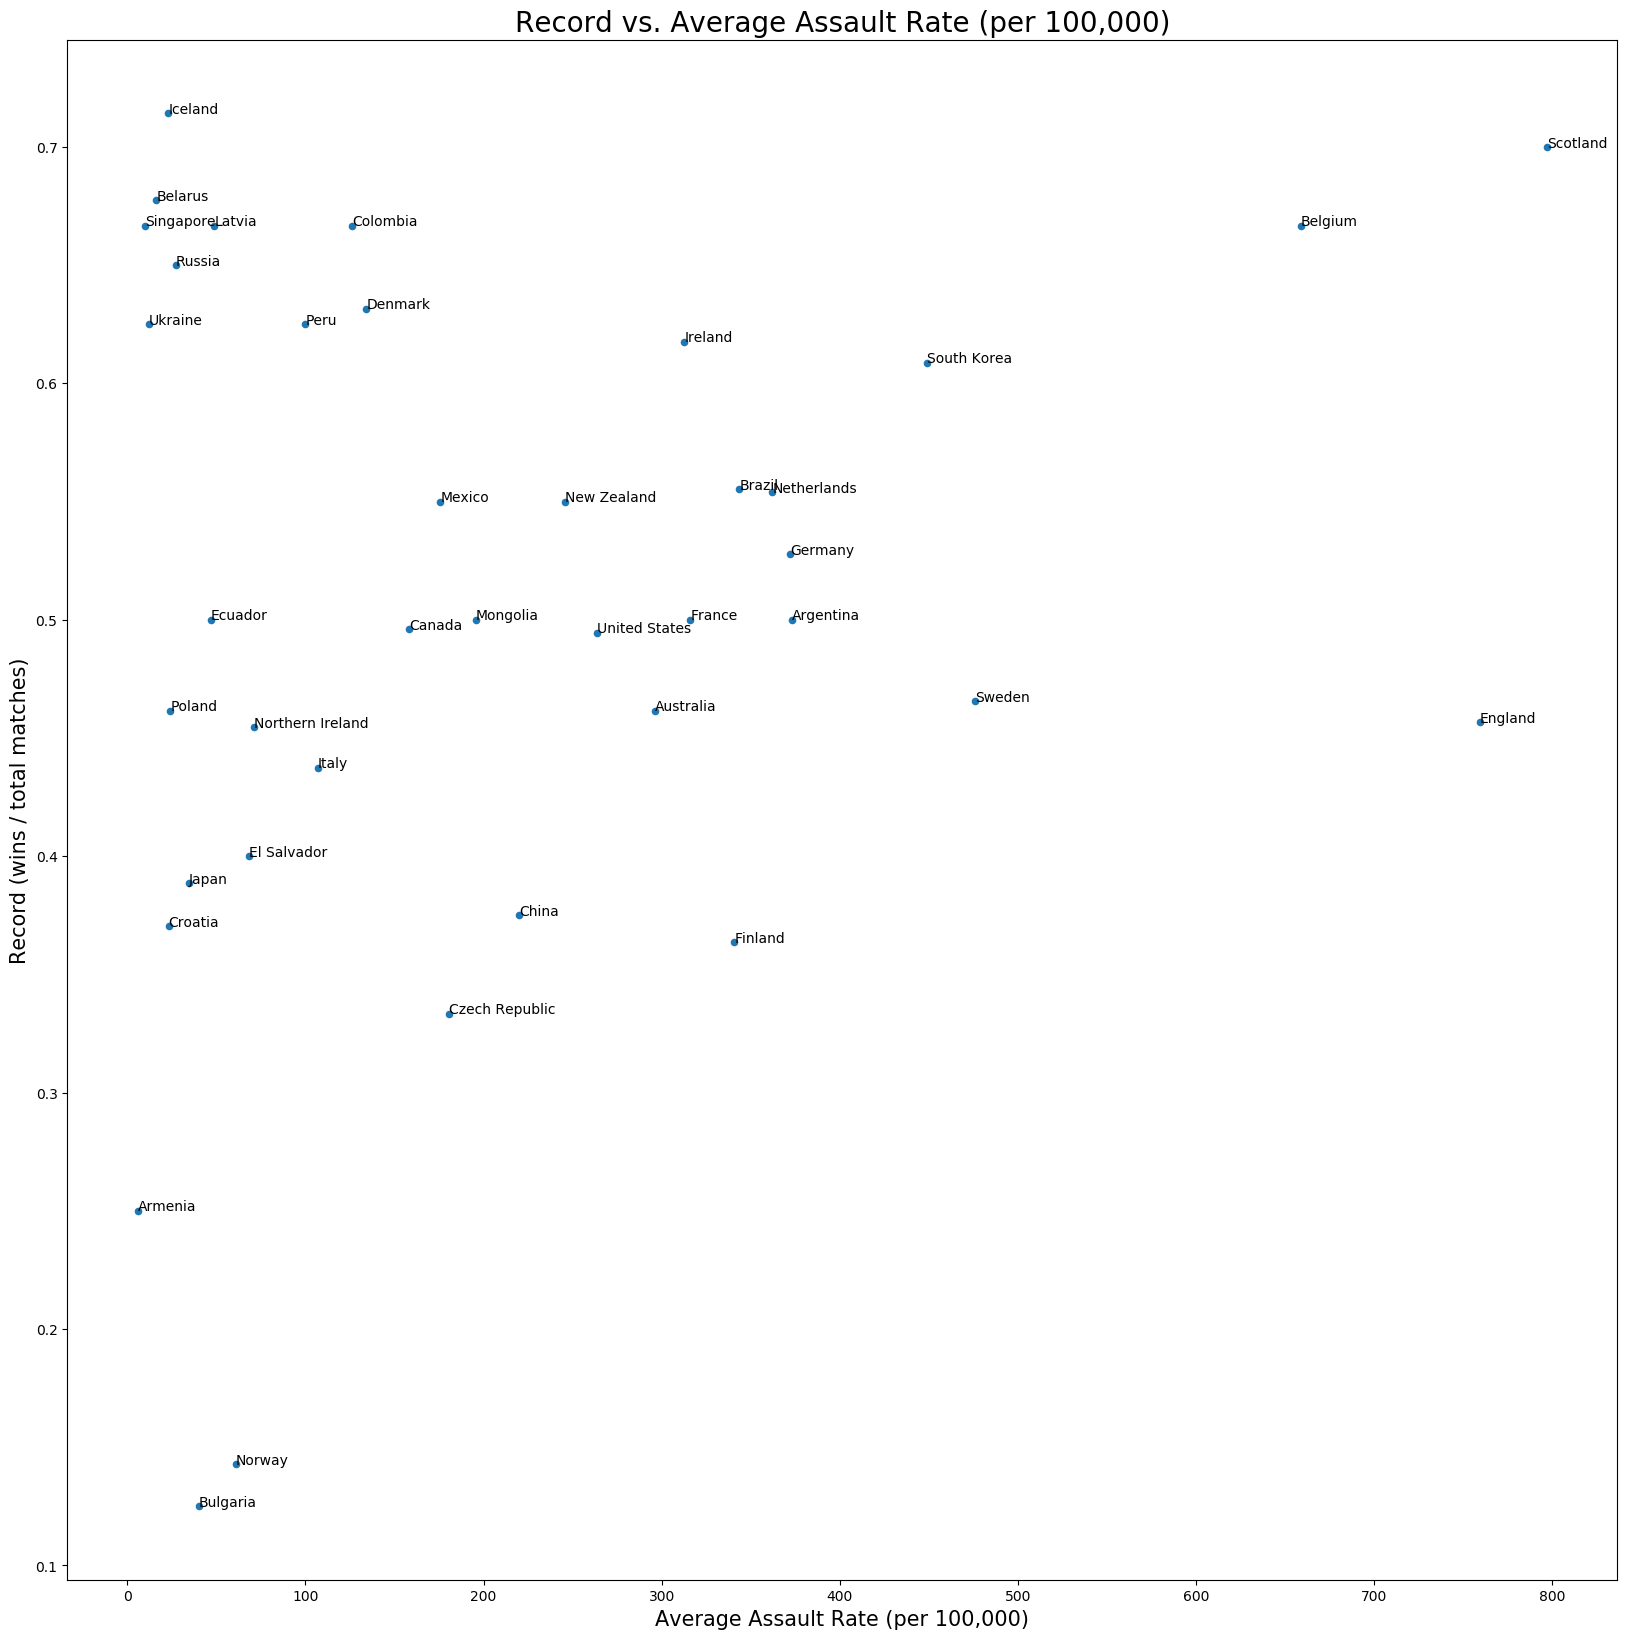

In [79]:
fig, ax = plt.subplots()
final_x_index_dropna_a.plot(x='average_assault_rate_per_100000', y ='record', ax=ax, kind='scatter', figsize = (20,20))
ax.set_title('Record vs. Average Assault Rate (per 100,000)', fontsize = 20)
ax.set_xlabel('Average Assault Rate (per 100,000)', fontsize = 15)
ax.set_ylabel('Record (wins / total matches)', fontsize = 15)


for i in range(0, len(final_x_index_dropna_a)):
    ax.annotate(final_x_index_dropna_a.iloc[i]['country'], xy = (final_x_index_dropna_a.iloc[i]['average_assault_rate_per_100000'], final_x_index_dropna_a.iloc[i]['record']))


In [80]:
plt.rcParams.update(plt.rcParamsDefault)

Here we graph UFC record versus homicide rate for each country. Again, we use a loop to annotate each point with country name.

From the graph, we can see that there seems to be a slightly positive correlation between homicide rate and record.

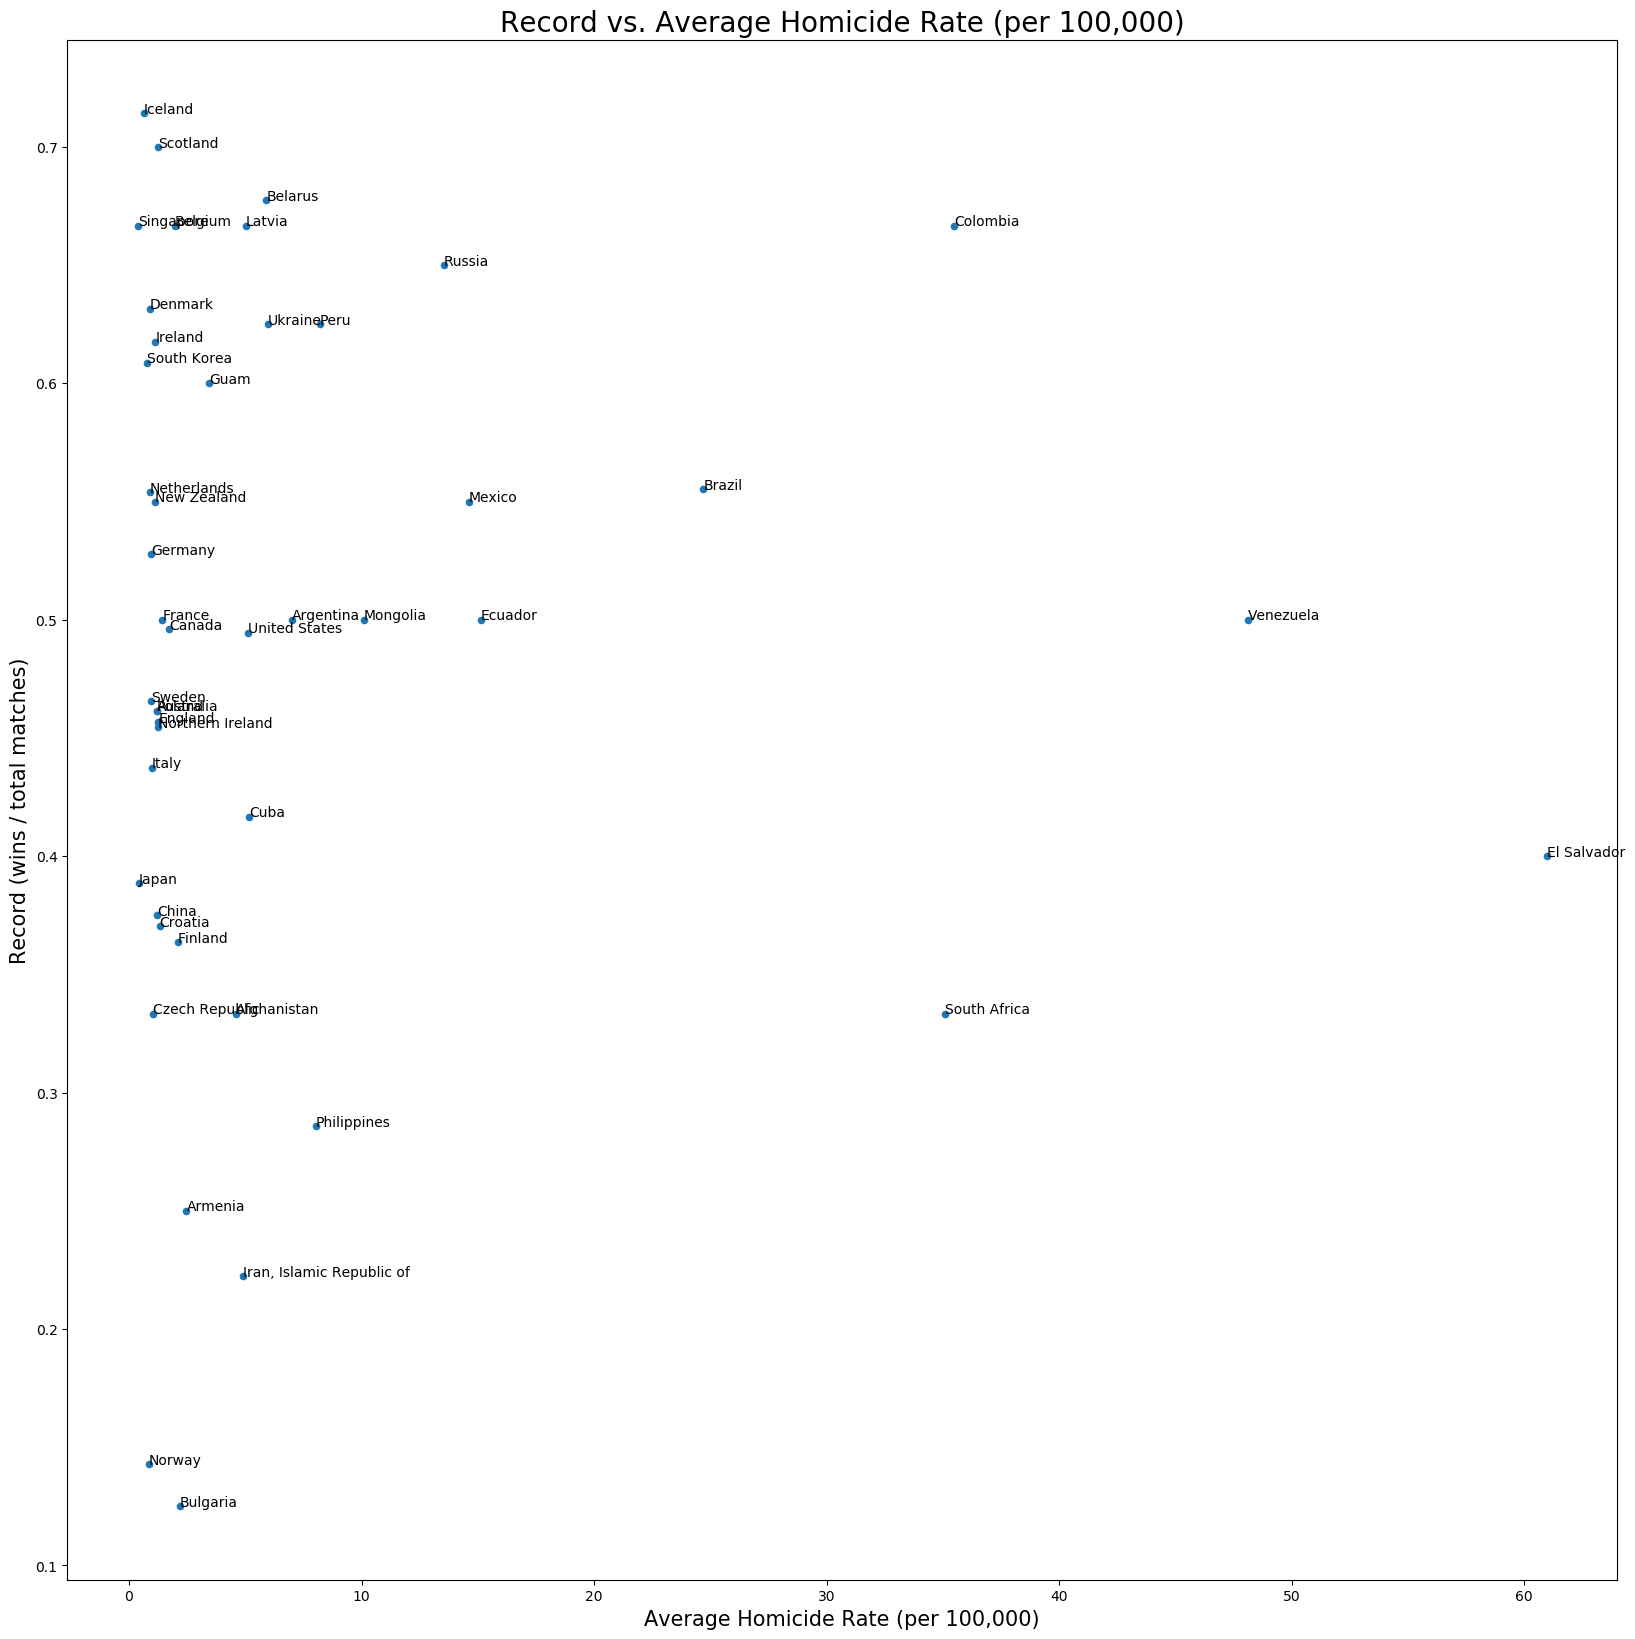

In [81]:
fig, ax = plt.subplots()
final_x_index.plot(x='average_homicide_rate_per_100000', y ='record', ax=ax, kind='scatter', figsize = (20,20))
ax.set_title('Record vs. Average Homicide Rate (per 100,000)', fontsize = 20)
ax.set_xlabel('Average Homicide Rate (per 100,000)', fontsize = 15)
ax.set_ylabel('Record (wins / total matches)', fontsize = 15)

for i in range(0, len(final_x_index)):
    ax.annotate(final_x_index.iloc[i]['country'], xy = (final_x_index.iloc[i]['average_homicide_rate_per_100000'], final_x_index.iloc[i]['record']))

Finally, we graph the relationship between UFC record and GDP PPP Per Capita in each country. Again we use a loop to annotate each point with country name. 

From the graph, there appears to be a slighly negative relationship between GDP and UFC record, although the graph is somewhat unclear.

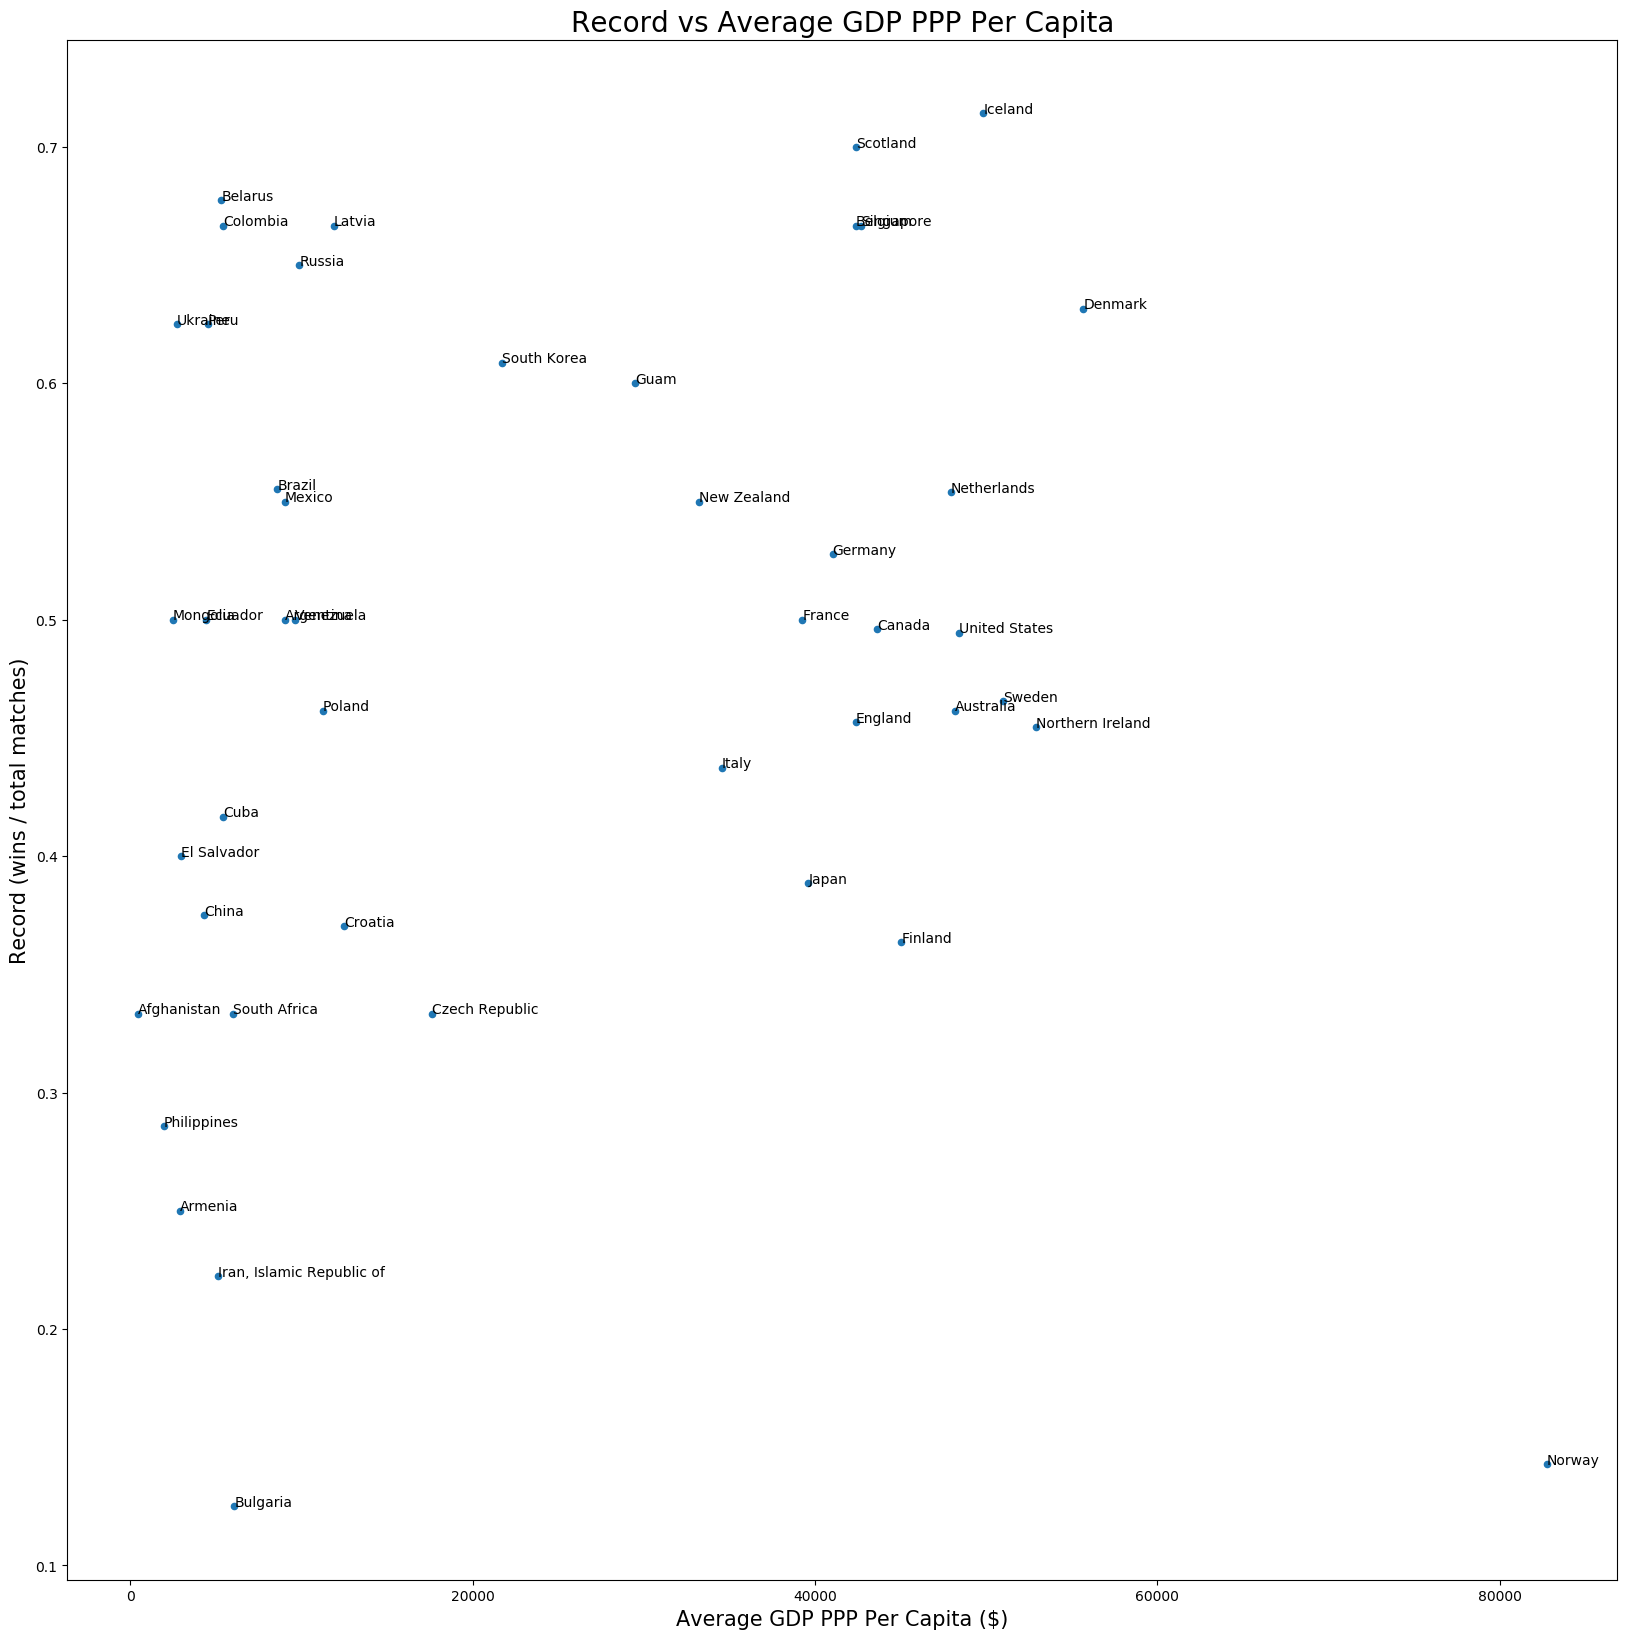

In [82]:
fig, ax = plt.subplots()
final_x.plot(x='average_gdp_ppp_per_capita', y ='record', ax=ax, kind='scatter', figsize = (20,20))
ax.set_title('Record vs Average GDP PPP Per Capita', fontsize = 20)
ax.set_xlabel('Average GDP PPP Per Capita ($)', fontsize = 15)
ax.set_ylabel('Record (wins / total matches)', fontsize = 15)

for i in range(0, len(final_x_index_dropna_b)):
    ax.annotate(final_x_index_dropna_b.iloc[i]['country'], xy = (final_x_index_dropna_b.iloc[i]['average_gdp_ppp_per_capita'], final_x_index_dropna_b.iloc[i]['record']))


Finally, we run a regression on all of our variables to check for statistical significance in the correlation between record and asault rate, homicide rate, and GDP. The coefficients for all our test variables are quite low, indicating that there is little correlation between record and each of our test variables after controlling for the other variables. The condition number, though is high, meaning that the output could change dramatically with changes to the input variables. This, it seems may be due to the fact that there are only around 40 countries with fighters competing in UFC and, thus, too few datapoints to run an accurate regression.

In [83]:
print(smf.ols('record ~ average_homicide_rate_per_100000 + average_assault_rate_per_100000 + average_gdp_ppp_per_capita' , data=final_x).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 record   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.6709
Date:                Fri, 21 Dec 2018   Prob (F-statistic):              0.576
Time:                        00:26:07   Log-Likelihood:                 21.335
No. Observations:                  38   AIC:                            -34.67
Df Residuals:                      34   BIC:                            -28.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep